# Volume-Adjusted $\tau$-Reset Liquidity Strategy

In [1]:
!pip install optuna dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [optuna]2m4/5 [optuna]g]


In [17]:
from dotenv import load_dotenv
import os
from datetime import datetime, UTC

from typing import List
from dataclasses import dataclass
import numpy as np
import pandas as pd
from fractal.core.base import Observation
from fractal.core.entities import UniswapV3LPGlobalState

from fractal.loaders.base_loader import LoaderType
from fractal.loaders.thegraph.uniswap_v3 import (
    UniswapV3EthereumPoolHourDataLoader, EthereumUniswapV3Loader, UniswapV3EthereumPoolMinuteDataLoader
)
from fractal.loaders.binance import BinanceHourPriceLoader, BinanceMinutePriceLoader
from fractal.loaders.structs import PriceHistory, PoolHistory

from fractal.core.base import Observation
from fractal.strategies.tau_reset_strategy import TauResetParams, TauResetStrategy

import optuna
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

@dataclass
class VolumeAdjustedParams:
    TAU: int
    BASE_DELTA: float
    K: float
    FEE: float
    INITIAL_BALANCE: float
    VOLUME_WINDOW: int

class VolumeAdjustedTauResetStrategy:
    def __init__(self, params: VolumeAdjustedParams, debug: bool = False):
        self.params = params
        self.debug = debug
        self.results = []

    def run(self, observations: List[Observation]):
        balance = self.params.INITIAL_BALANCE
        last_reset = None
        liquidity = 0
        current_price = None
        volume_series = []

        for i, obs in enumerate(observations):
            ts = obs.timestamp
            state: UniswapV3LPGlobalState = obs.states['UNISWAP_V3']
            price = state.price
            volume = state.volume
            volume_series.append(volume)

            if i < self.params.VOLUME_WINDOW:
                self.results.append({"timestamp": ts, "price": price, "balance": balance})
                continue

            if last_reset is None or (ts - last_reset).total_seconds() >= self.params.TAU * 3600:
                recent_volumes = volume_series[-self.params.VOLUME_WINDOW:]
                volume_mean = np.mean(recent_volumes)
                volume_rel = volume / volume_mean if volume_mean > 0 else 1.0

                delta = self.params.BASE_DELTA + self.params.K * (volume_rel - 1)

                delta = np.clip(delta, 0.01, 0.2)

                if current_price is not None:
                    ratio = price / current_price
                    il = (2 * np.sqrt(ratio) / (1 + ratio)) - 1
                    balance *= (1 + il)

                lower = price * (1 - delta)
                upper = price * (1 + delta)
                sqrt_diff = np.sqrt(upper) - np.sqrt(lower)
                liquidity = balance / sqrt_diff
                balance -= liquidity * self.params.FEE  # комиссия

                last_reset = ts
                current_price = price

                if self.debug:
                    print(f"[{ts}] Δ={delta:.3f}, Volume={volume:.0f}, New LP={liquidity:.2f}, Balance={balance:.2f}")

            self.results.append({"timestamp": ts, "price": price, "balance": balance})

        return self

    def to_dataframe(self):
        return pd.DataFrame(self.results).set_index("timestamp")

    def get_default_metrics(self):
        df = self.to_dataframe()
        returns = df["balance"].pct_change().dropna()
        pnl = df["balance"].iloc[-1] / df["balance"].iloc[0] - 1
        sharpe = returns.mean() / returns.std() * np.sqrt(365 * 24 / self.params.TAU) if not returns.empty else 0
        mdd = (df["balance"] / df["balance"].cummax() - 1).min()
        return {
            "PnL (%)": round(pnl * 100, 2),
            "Sharpe": round(sharpe, 2),
            "Max Drawdown (%)": round(mdd * 100, 2)
        }

# Volume-Volatility Adjusted 𝜏-reset strategy

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
@dataclass
class CombinedParams:
    TAU: int
    BASE_DELTA: float
    KV: float
    KVEL: float
    KSIGMA: float
    FEE: float
    INITIAL_BALANCE: float
    WINDOW: int

class VolumeVolatilityTauResetStrategy:
    def __init__(self, params: CombinedParams, debug=False):
        self.params = params
        self.debug = debug
        self.results = []

    def run(self, observations: List[Observation]):
        balance = self.params.INITIAL_BALANCE
        last_reset = None
        liquidity = 0
        current_price = None

        price_series = []
        volume_series = []

        for i, obs in enumerate(observations):
            ts = obs.timestamp
            state: UniswapV3LPGlobalState = obs.states['UNISWAP_V3']
            price = state.price
            volume = state.volume

            price_series.append(price)
            volume_series.append(volume)

            if i < self.params.WINDOW:
                self.results.append({"timestamp": ts, "price": price, "balance": balance})
                continue

            # calculate dynamic TAU based on volatility
            if len(price_series) >= self.params.WINDOW:
                sigma = np.std(price_series[-self.params.WINDOW:])
                mean_price = np.mean(price_series[-self.params.WINDOW:])
                sigma_rel = sigma / mean_price if mean_price > 0 else 0.0
            
                dynamic_tau_hours = self.params.TAU / (1 + 5 * sigma_rel)
                dynamic_tau_hours = np.clip(dynamic_tau_hours, 6, 48)  # ограничим 6-48ч
            
                if last_reset is None or (ts - last_reset).total_seconds() >= dynamic_tau_hours * 3600:


            # if last_reset is None or (ts - last_reset).total_seconds() >= self.params.TAU * 3600:
                    vol_window = np.array(volume_series[-self.params.WINDOW:])
                    price_window = np.array(price_series[-self.params.WINDOW:])
                    
                    # Простой EMA-скользящий средний
                    ema_volume = pd.Series(volume_series).ewm(span=self.params.WINDOW).mean().iloc[-1]
                    ema_sigma = pd.Series(price_series).ewm(span=self.params.WINDOW).std().iloc[-1]
                    mean_volume = ema_volume
                    mean_sigma = ema_sigma
                    # mean_volume = np.mean(vol_window)
                    # mean_sigma = np.std(price_window)
    
                    vol_rel = volume / mean_volume if mean_volume > 0 else 1.0
                    sigma_rel = np.std(price_window[-5:]) / mean_sigma if mean_sigma > 0 else 1.0
                    
                    # delta = self.params.BASE_DELTA + self.params.KV * (vol_rel - 1) + self.params.KSIGMA * (sigma_rel - 1)
                    # delta = np.clip(delta, 0.01, 0.2)
    
                    #### new feature "velocity" instead of "volatile"
                    velocity = price / price_series[-2] - 1
                    # delta = self.params.BASE_DELTA + self.params.KV * (vol_rel - 1) + self.params.KVEL * velocity
                    # delta = np.clip(delta, 0.01, 0.2)
                    # delta = 0.01 + 0.19 * (1 - np.exp(-5 * delta))  # sigmoid-style cap
                    ####

                    ####
                    volume_score = np.log(vol_rel + 1e-6)
                    sigma_score = np.log(sigma_rel + 1e-6)
                    velocity_score = velocity
                    
                    delta = self.params.BASE_DELTA * (1 + 0.3 * volume_score + 0.3 * sigma_score + 0.3 * velocity_score)
                    delta = np.clip(delta, 0.01, 0.25)
                    ####
                    
          
                    #### TREND FILTER
                    trend = (price - np.mean(price_series[-self.params.WINDOW:])) / price
                    trend_adjustment = 1 - 0.5 * trend
                    delta *= np.clip(trend_adjustment, 0.5, 1.5)
                    if delta < 0.001:
                        continue
                    ####
    
                    if current_price is not None:
                        ratio = price / current_price
                        il = (2 * np.sqrt(ratio) / (1 + ratio)) - 1
                        balance *= (1 + il)

                    #### Momentum filter
                    momentum = price / price_series[-12] - 1
                    
                    # Не входим, если рынок слишком трендовый
                    # if abs(momentum) > 0.05:  # 5% — гиперпараметр
                    #     if self.debug:
                    #         print(f"[{ts}] Momentum too strong ({momentum:.2%}), skip reset")
                    #     self.results.append({"timestamp": ts, "price": price, "balance": balance})
                    #     continue
                    ####

                    #### Moving avg filter
                    # moving_avg = np.mean(price_series[-24:])
                    # deviation = abs(price - moving_avg) / moving_avg
                    
                    # if deviation > 0.05:  # Цена улетела от среднего — высок риск IL
                    #     if self.debug:
                    #         print(f"[{ts}] Price too far from mean, skip")
                    #     self.results.append({"timestamp": ts, "price": price, "balance": balance})
                    #   continue
                    ####
    
                    #### LP WITH TREND skew
                    # skew = 0.5 + 0.3 * trend  # например, от 0.2 до 0.8
                    skew = 0.5 + 0.2 * np.clip(trend, -1, 1)
                    lower = price * (1 - delta * skew)
                    upper = price * (1 + delta * (1 - skew))
    
                    # lower = price * (1 - delta)
                    # upper = price * (1 + delta)
                    sqrt_diff = np.sqrt(upper) - np.sqrt(lower)
                
                    ####
                    confidence = sigmoid(volume_score + sigma_score + velocity_score)
                    lp_fraction = 0.1 + 0.4 * confidence  # 10%–50%
                    
                    liquidity = balance * lp_fraction
                    ####
                                        
                    # liquidity = balance / sqrt_diff
                    balance -= liquidity * self.params.FEE
    
                    last_reset = ts
                    current_price = price
    
                    if self.debug:
                        print(f"[{ts}] Δ={delta:.3f}, Volume={volume:.0f}, σ_rel={sigma_rel:.2f}, New LP={liquidity:.2f}, Balance={balance:.2f}")

            self.results.append({"timestamp": ts, "price": price, "balance": balance})

        return self

    def to_dataframe(self):
        return pd.DataFrame(self.results).set_index("timestamp")

    def get_default_metrics(self):
        df = self.to_dataframe()
        returns = df["balance"].pct_change().dropna()
        pnl = df["balance"].iloc[-1] / df["balance"].iloc[0] - 1
        sharpe = returns.mean() / returns.std() * np.sqrt(365 * 24 / self.params.TAU) if not returns.empty else 0
        mdd = (df["balance"] / df["balance"].cummax() - 1).min()
        return {
            "PnL (%)": round(pnl * 100, 2),
            "Sharpe": round(sharpe, 2),
            "Max Drawdown (%)": round(mdd * 100, 2)
        }

# Get historical data

In [5]:
def get_observations(
        pool_data: PoolHistory, price_data: PriceHistory,
        start_time: datetime = None, end_time: datetime = None
    ) -> List[Observation]:
    """
    Get observations from the pool and price data for the TauResetStrategy.

    Returns:
        List[Observation]: The observation list for TauResetStrategy.
    """
    observations_df: pd.DataFrame = pool_data.join(price_data)
    observations_df = observations_df.dropna()
    observations_df = observations_df.loc[start_time:end_time]
    if start_time is None:
        start_time = observations_df.index.min()
    if end_time is None:
        end_time = observations_df.index.max()
    observations_df = observations_df[observations_df.tvl > 0]
    observations_df = observations_df.sort_index()
    return [
        Observation(
            timestamp=timestamp,
            states={
                'UNISWAP_V3': UniswapV3LPGlobalState(price=price, tvl=tvls, volume=volume, fees=fees, liquidity=liquidity),
            }
        ) for timestamp, (tvls, volume, fees, liquidity, price) in observations_df.iterrows()
    ]

In [6]:
def build_observations(
        ticker: str, pool_address: str, api_key: str,
        start_time: datetime = None, end_time: datetime = None, fidelity: str = 'hour',
    ) -> List[Observation]:
    """
    Build observations for the TauResetStrategy from the given start and end time.
    """
    if fidelity == 'hour':
        pool_data: PoolHistory = UniswapV3EthereumPoolHourDataLoader(
            api_key, pool_address, loader_type=LoaderType.CSV).read(with_run=True)
        binance_prices: PriceHistory = BinanceHourPriceLoader(ticker, loader_type=LoaderType.CSV).read(with_run=True)
    elif fidelity == 'minute':
        pool_data: PoolHistory = UniswapV3EthereumPoolMinuteDataLoader(
            api_key, pool_address, loader_type=LoaderType.CSV).read(with_run=True)
        binance_prices: PriceHistory = BinanceMinutePriceLoader(ticker, loader_type=LoaderType.CSV,
                                                                start_time=start_time, end_time=end_time).read(with_run=True)
    else:
        raise ValueError("Fidelity must be either 'hour' or 'minute'.")
    return get_observations(pool_data, binance_prices, start_time, end_time)

In [7]:
load_dotenv()
THE_GRAPH_API_KEY = os.getenv('THE_GRAPH_API_KEY')
ticker: str = 'ETHUSDT'
pool_address: str = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
THE_GRAPH_API_KEY = THE_GRAPH_API_KEY

# Load data
token0_decimals, token1_decimals = EthereumUniswapV3Loader(
THE_GRAPH_API_KEY, loader_type=LoaderType.CSV).get_pool_decimals(pool_address)

observations: List[Observation] = build_observations(
    ticker=ticker, pool_address=pool_address, api_key=THE_GRAPH_API_KEY,
    start_time=datetime(2024, 5, 1, tzinfo=UTC), end_time=datetime(2025, 5, 1, tzinfo=UTC),
    fidelity='hour'
)

/app/venv/lib/python3.12/site-packages/fractal/loaders/thegraph/uniswap_v3/uniswap_v3_pool.py:153: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self._data = self._data.resample('H').ffill()
/app/venv/lib/python3.12/site-packages/fractal/loaders/thegraph/uniswap_v3/uniswap_v3_pool.py:153: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  self._data = self._data.resample('H').ffill()


# Volume adj

## Lets try to find the best params

In [8]:
def volume_objective(trial):
    params = VolumeAdjustedParams(
        TAU=trial.suggest_int('TAU', 12, 72),
        BASE_DELTA=trial.suggest_float('BASE_DELTA', 0.01, 0.15),
        K=trial.suggest_float('K', 0.001, 0.08),
        FEE=0.003,
        INITIAL_BALANCE=1_000_000,
        VOLUME_WINDOW=trial.suggest_int('VOLUME_WINDOW', 12, 96),
    )

    tscv = TimeSeriesSplit(n_splits=3)
    metrics = []

    for train_idx, _ in tscv.split(observations):
        train_obs = [observations[i] for i in train_idx]

        strategy = VolumeAdjustedTauResetStrategy(params, debug=False)
        result = strategy.run(train_obs)
        stats = result.get_default_metrics()
        sharpe = stats["Sharpe"]
        pnl = stats["PnL (%)"]

        # Комбинируем метрику: Sharpe + alpha * PnL
        score = sharpe + 0.01 * pnl
        metrics.append(score)

    return np.mean(metrics)

In [11]:
study_volume = optuna.create_study(direction='maximize')
study_volume.optimize(volume_objective, n_trials=100)

best_params_v = study_volume.best_params
print(f"Best parameters: {best_params_v}")

[I 2025-05-19 02:59:48,511] A new study created in memory with name: no-name-51b3cc0f-3549-4346-94dd-36468ed7d7df
[I 2025-05-19 02:59:48,731] Trial 0 finished with value: -3.6173333333333333 and parameters: {'TAU': 24, 'BASE_DELTA': 0.08685956672131077, 'K': 0.05084066823664895, 'VOLUME_WINDOW': 88}. Best is trial 0 with value: -3.6173333333333333.
[I 2025-05-19 02:59:48,902] Trial 1 finished with value: -2.1100333333333334 and parameters: {'TAU': 35, 'BASE_DELTA': 0.14387411148387846, 'K': 0.04899658066460111, 'VOLUME_WINDOW': 60}. Best is trial 1 with value: -2.1100333333333334.
[I 2025-05-19 02:59:49,141] Trial 2 finished with value: -1.1320333333333334 and parameters: {'TAU': 67, 'BASE_DELTA': 0.1294537013548176, 'K': 0.07952468685739404, 'VOLUME_WINDOW': 78}. Best is trial 2 with value: -1.1320333333333334.
[I 2025-05-19 02:59:49,333] Trial 3 finished with value: -3.6534333333333335 and parameters: {'TAU': 26, 'BASE_DELTA': 0.05099872774766042, 'K': 0.006799384190346815, 'VOLUME_W

Best parameters: {'TAU': 72, 'BASE_DELTA': 0.14962497612346326, 'K': 0.031950763850680484, 'VOLUME_WINDOW': 84}


In [12]:
params = VolumeAdjustedParams(
    TAU=best_params_v['TAU'],
    BASE_DELTA=best_params_v['BASE_DELTA'],
    K=best_params_v['K'],
    FEE=0.003,
    INITIAL_BALANCE=1_000_000,
    VOLUME_WINDOW=best_params_v['VOLUME_WINDOW']
)

In [13]:
# train_obs = observations[:int(0.7 * len(observations))]
test_obs = observations[int(0.7 * len(observations)):]

strategy_v = VolumeAdjustedTauResetStrategy(params=params, debug=True)
result_v = strategy_v.run(test_obs)
df_v = result_v.to_dataframe()
print(result_v.get_default_metrics())
df_v.to_csv("volume_adjusted_tau_result.csv")

[2025-01-15 00:00:00+00:00] Δ=0.147, Volume=290176, New LP=119642.51, Balance=999641.07
[2025-01-18 00:00:00+00:00] Δ=0.175, Volume=450491, New LP=96406.85, Balance=998566.83
[2025-01-21 00:00:00+00:00] Δ=0.134, Volume=350596, New LP=131094.04, Balance=997425.56
[2025-01-24 00:00:00+00:00] Δ=0.138, Volume=242987, New LP=125638.16, Balance=997008.51
[2025-01-27 00:00:00+00:00] Δ=0.196, Volume=434839, New LP=89317.13, Balance=996679.66
[2025-01-30 00:00:00+00:00] Δ=0.140, Volume=214000, New LP=127519.93, Balance=996197.05
[2025-02-02 00:00:00+00:00] Δ=0.196, Volume=746027, New LP=90144.63, Balance=995917.33
[2025-02-05 00:00:00+00:00] Δ=0.135, Volume=1451837, New LP=140287.94, Balance=992924.71
[2025-02-08 00:00:00+00:00] Δ=0.131, Volume=629873, New LP=147036.39, Balance=992367.45
[2025-02-11 00:00:00+00:00] Δ=0.157, Volume=1224518, New LP=121453.62, Balance=991943.34
[2025-02-14 00:00:00+00:00] Δ=0.136, Volume=615194, New LP=140775.70, Balance=991505.17
[2025-02-17 00:00:00+00:00] Δ=0.1

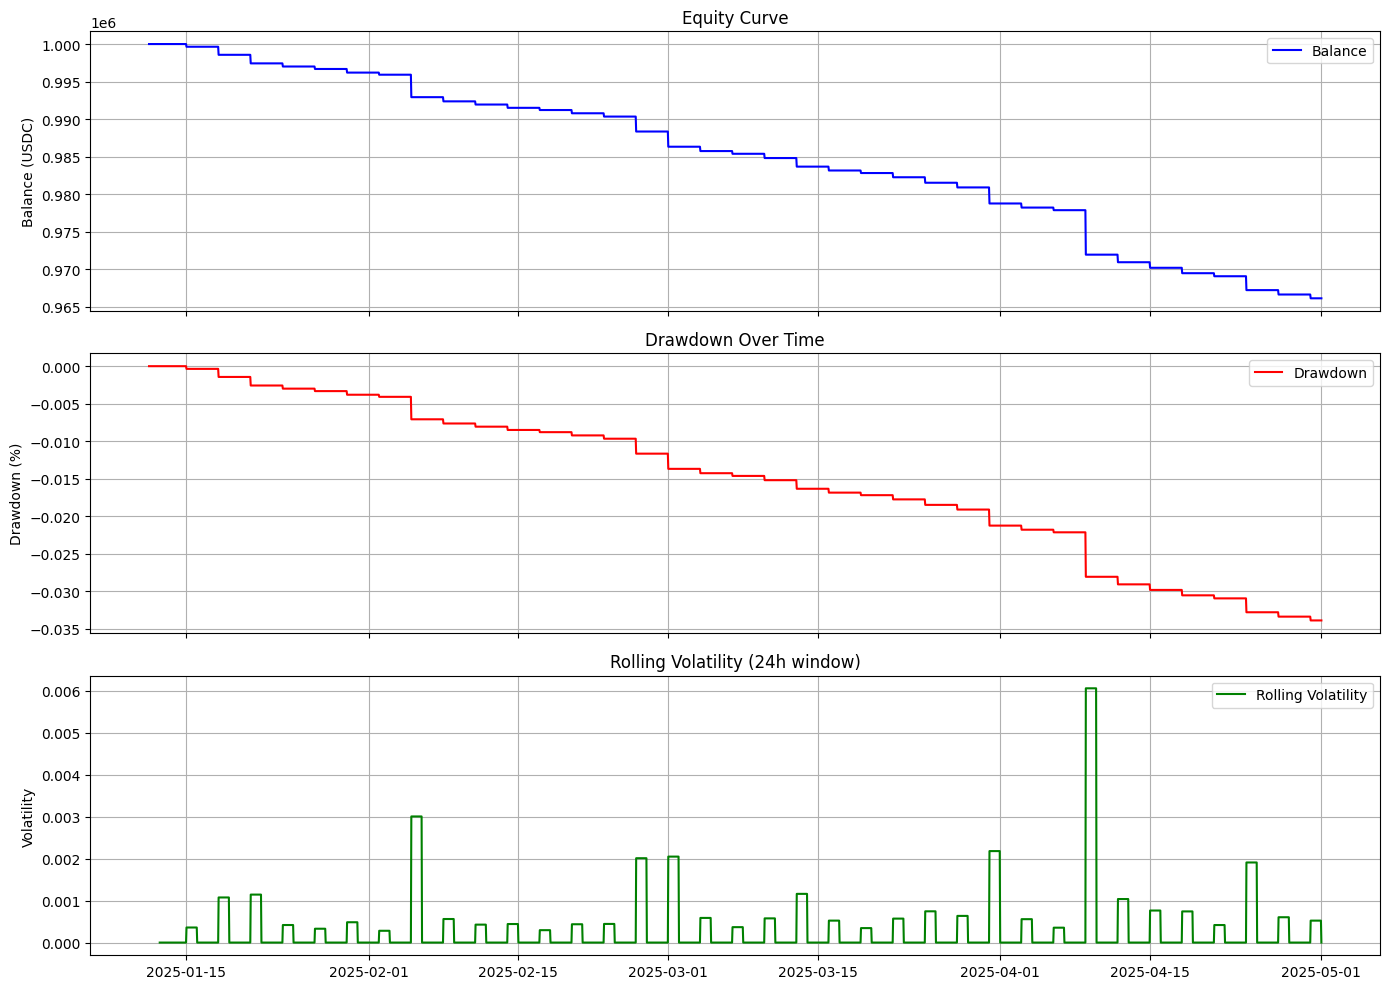

In [20]:
df_v['peak'] = df_v['balance'].cummax()
df_v['drawdown'] = df_v['balance'] / df_v['peak'] - 1

df_v['returns'] = df_v['balance'].pct_change()
df_v['rolling_vol'] = df_v['returns'].rolling(window=24).std() * (24**0.5)  # 24-часовое окно

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axs[0].plot(df_v.index, df_v['balance'], label='Balance', color='blue')
axs[0].set_title("Equity Curve")
axs[0].set_ylabel("Balance (USDC)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(df_v.index, df_v['drawdown'], label='Drawdown', color='red')
axs[1].set_title("Drawdown Over Time")
axs[1].set_ylabel("Drawdown (%)")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(df_v.index, df_v['rolling_vol'], label='Rolling Volatility', color='green')
axs[2].set_title("Rolling Volatility (24h window)")
axs[2].set_ylabel("Volatility")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Combined strat: Volatility + Volume

## Lets try to find the best params

In [21]:
def objective(trial):
    params = CombinedParams(
        TAU=trial.suggest_int('TAU', 12, 72),
        BASE_DELTA=trial.suggest_float('BASE_DELTA', 0.01, 0.15),
        KV=trial.suggest_float('KV', 0.001, 0.08),
        KVEL=trial.suggest_float('KVEL', 0.001, 0.08),
        KSIGMA=trial.suggest_float('KSIGMA', 0.001, 0.08),
        FEE=0.003,
        INITIAL_BALANCE=1_000_000,
        WINDOW=trial.suggest_int('WINDOW', 12, 96),
    )

    tscv = TimeSeriesSplit(n_splits=3)
    metrics = []

    for train_idx, _ in tscv.split(observations):
        train_obs = [observations[i] for i in train_idx]

        strategy = VolumeVolatilityTauResetStrategy(params, debug=False)
        result = strategy.run(train_obs)
        stats = result.get_default_metrics()
        sharpe = stats["Sharpe"]
        pnl = stats["PnL (%)"]

        # Комбинируем метрику: Sharpe + alpha * PnL
        score = sharpe + 0.01 * pnl
        metrics.append(score)

    return np.mean(metrics)

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-05-19 03:02:43,699] A new study created in memory with name: no-name-6e594c44-7ea2-49a7-b77f-424badd19abc
[I 2025-05-19 03:02:46,230] Trial 0 finished with value: -1.5886000000000002 and parameters: {'TAU': 55, 'BASE_DELTA': 0.05271718853261975, 'KV': 0.0095775820645677, 'KVEL': 0.059117103199966936, 'KSIGMA': 0.005683237195045155, 'WINDOW': 54}. Best is trial 0 with value: -1.5886000000000002.
[I 2025-05-19 03:02:48,764] Trial 1 finished with value: -1.3465666666666667 and parameters: {'TAU': 63, 'BASE_DELTA': 0.1373675310731457, 'KV': 0.03639866446695383, 'KVEL': 0.023180359264553693, 'KSIGMA': 0.05210426089730764, 'WINDOW': 93}. Best is trial 1 with value: -1.3465666666666667.
[I 2025-05-19 03:02:51,347] Trial 2 finished with value: -1.7930666666666664 and parameters: {'TAU': 45, 'BASE_DELTA': 0.11657721984953211, 'KV': 0.0014845892474234074, 'KVEL': 0.02240922122098454, 'KSIGMA': 0.04156308919794712, 'WINDOW': 60}. Best is trial 1 with value: -1.3465666666666667.
[I 2025-05

Best parameters: {'TAU': 66, 'BASE_DELTA': 0.0715147574756703, 'KV': 0.006230317902035174, 'KVEL': 0.04340656452262386, 'KSIGMA': 0.04117856197631081, 'WINDOW': 62}


In [23]:
params = CombinedParams(
    TAU=best_params['TAU'],
    BASE_DELTA=best_params['BASE_DELTA'],
    KV=best_params['KV'],
    KVEL=best_params['KVEL'], # feat
    KSIGMA=best_params['KSIGMA'],
    FEE=0.003,
    INITIAL_BALANCE=1_000_000,
    WINDOW=best_params['WINDOW']
)

# fix for overfitting

In [24]:
# train_obs = observations[:int(0.7 * len(observations))]
test_obs = observations[int(0.7 * len(observations)):]

strategy = VolumeVolatilityTauResetStrategy(params, debug=True)
result = strategy.run(test_obs)
df = result.to_dataframe()
print(result.get_default_metrics())
df.to_csv("combined_volume_volatility_strategy.csv")

[2025-01-14 02:00:00+00:00] Δ=0.010, Volume=208808, σ_rel=0.09, New LP=115801.22, Balance=999652.60
[2025-01-16 02:00:00+00:00] Δ=0.034, Volume=249126, σ_rel=0.22, New LP=160851.57, Balance=998561.55
[2025-01-18 02:00:00+00:00] Δ=0.038, Volume=450491, σ_rel=0.13, New LP=170743.94, Balance=998002.64
[2025-01-20 02:00:00+00:00] Δ=0.058, Volume=923882, σ_rel=0.38, New LP=234636.04, Balance=996825.78
[2025-01-22 02:00:00+00:00] Δ=0.016, Volume=163409, σ_rel=0.24, New LP=127057.47, Balance=996331.65
[2025-01-24 02:00:00+00:00] Δ=0.046, Volume=242987, σ_rel=0.44, New LP=191493.82, Balance=995718.12
[2025-01-26 02:00:00+00:00] Δ=0.018, Volume=110618, σ_rel=0.13, New LP=129646.23, Balance=995308.54
[2025-01-28 02:00:00+00:00] Δ=0.015, Volume=208732, σ_rel=0.10, New LP=125668.20, Balance=994716.15
[2025-01-30 02:00:00+00:00] Δ=0.031, Volume=214000, σ_rel=0.22, New LP=151275.09, Balance=994245.11
[2025-02-01 02:00:00+00:00] Δ=0.012, Volume=226904, σ_rel=0.09, New LP=122869.61, Balance=993606.49


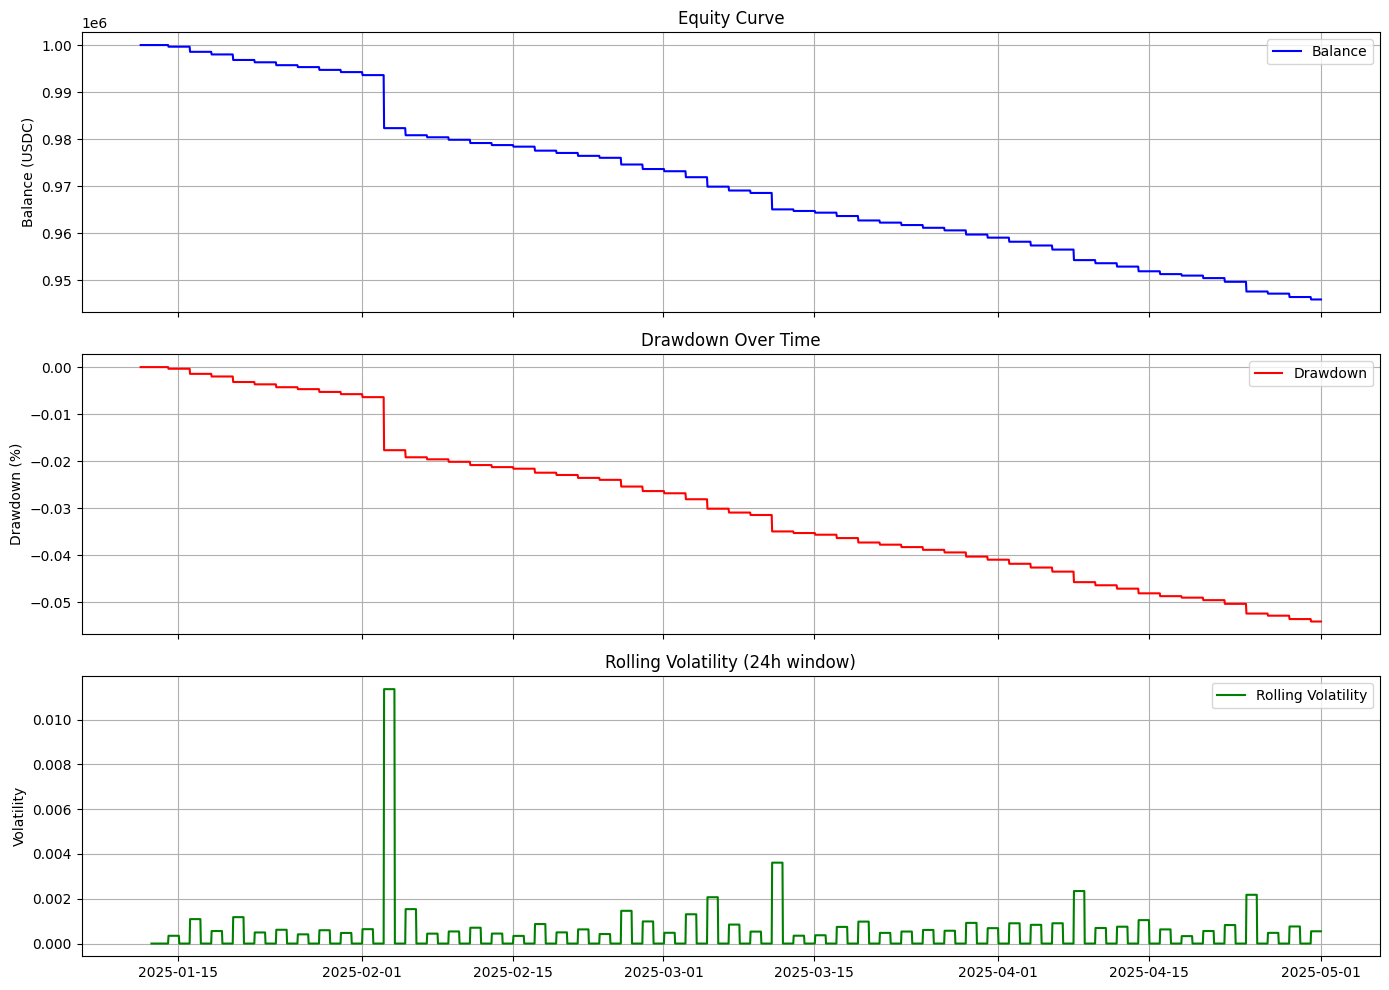

In [26]:
df['peak'] = df['balance'].cummax()
df['drawdown'] = df['balance'] / df['peak'] - 1

df['returns'] = df['balance'].pct_change()
df['rolling_vol'] = df['returns'].rolling(window=24).std() * (24**0.5)  # 24-часовое окно

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axs[0].plot(df.index, df['balance'], label='Balance', color='blue')
axs[0].set_title("Equity Curve")
axs[0].set_ylabel("Balance (USDC)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(df.index, df['drawdown'], label='Drawdown', color='red')
axs[1].set_title("Drawdown Over Time")
axs[1].set_ylabel("Drawdown (%)")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(df.index, df['rolling_vol'], label='Rolling Volatility', color='green')
axs[2].set_title("Rolling Volatility (24h window)")
axs[2].set_ylabel("Volatility")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()